`ADVERSARIAL REGULARIZATION FOR IMAGE CLASSIFIER.`

In [1]:
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Model
from tensorflow.keras import layers, Input
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Reshape, Dense, Add
from keras.utils import get_custom_objects, plot_model
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array
from tensorflow.keras.optimizers import Nadam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [5]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [6]:
input_layer = Input(shape=(28, 28, 1))
x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(input_layer)
x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(10, activation="softmax", name="output_layer")(x)

model1 = Model(inputs=input_layer, outputs=output_layer)

2024-02-18 17:13:47.167370: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-02-18 17:13:47.167399: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-18 17:13:47.167406: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-18 17:13:47.167441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 17:13:47.167459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# model = tf.keras.Sequential(
#     layers.Conv2D(32, kernel_size = (3, 3), activation = "relu", input_shape = (28, 28, 1)),
#     layers.Conv2D(64, kernel_size = (3, 3), activation = "relu"),
#     layers.MaxPooling2D(pool_size = (2, 2)),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation = "relu"),
#     layers.Dropout(0.5),
#     layers.Dense(10, activation = "softmax", name = "output_layer")
# )

In [8]:
model1.compile(optimizer = 'nadam',
              loss = 'categorical_crossentropy',
              metrics = [categorical_accuracy])

Add Early stopping.

In [9]:
stop_early = EarlyStopping(monitor = "val_categorical_accuracy", min_delta = 0,
                           patience = 20, mode = "auto",
                           baseline = None, restore_best_weights = True)

In [10]:
history = model1.fit(x_train, y_train,
                    batch_size = 128, epochs = 100,
                    validation_data = (x_test, y_test),
                    callbacks = [stop_early])

Epoch 1/100


2024-02-18 17:13:47.843772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 [==============================] - 13s 25ms/step - loss: 0.2548 - categorical_accuracy: 0.9248 - val_loss: 0.0635 - val_categorical_accuracy: 0.9815
Epoch 2/100
469/469 [==============================] - 12s 25ms/step - loss: 0.1599 - categorical_accuracy: 0.9632 - val_loss: 0.0665 - val_categorical_accuracy: 0.9845
Epoch 3/100
469/469 [==============================] - 12s 25ms/step - loss: 0.2123 - categorical_accuracy: 0.9660 - val_loss: 0.0970 - val_categorical_accuracy: 0.9844
Epoch 4/100
469/469 [==============================] - 12s 25ms/step - loss: 0.2714 - categorical_accuracy: 0.9672 - val_loss: 0.1641 - val_categorical_accuracy: 0.9804
Epoch 5/100
469/469 [==============================] - 12s 25ms/step - loss: 0.3886 - categorical_accuracy: 0.9669 - val_loss: 0.1883 - val_categorical_accuracy: 0.9836
Epoch 6/100
469/469 [==============================] - 12s 25ms/step - loss: 0.5341 - categorical_accuracy: 0.9679 - val_loss: 0.2479 - val_categorical_accuracy: 0.987

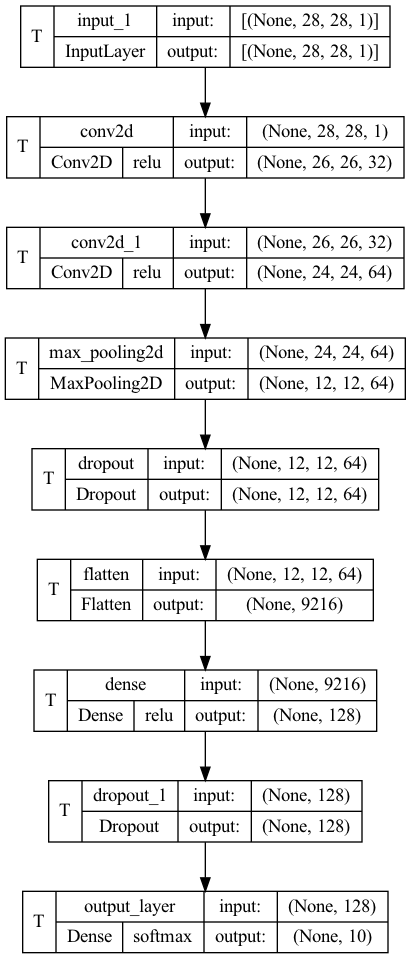

In [11]:
tf.keras.utils.plot_model(model1,
                          to_file='model.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

Model Evaluation.

In [12]:
train_evaluation = model1.evaluate(x_train, y_train)

print(train_evaluation)

1875/1875 [==============================] - 16s 9ms/step - loss: 0.2041 - categorical_accuracy: 0.9884
[0.20414313673973083, 0.9883833527565002]


In [13]:
test_evaluation = model1.evaluate(x_test, y_test)

print(test_evaluation)

313/313 [==============================] - 3s 9ms/step - loss: 0.2479 - categorical_accuracy: 0.9871
[0.24788078665733337, 0.9871000051498413]


Select an image to create  an adversarial example from.

In [14]:
image = x_train[0 : 1]

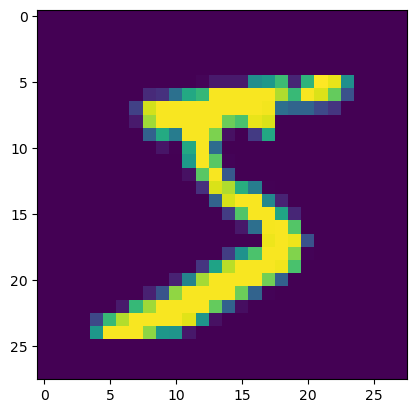

In [15]:
plt.imshow(image.reshape((28, 28)), vmin = 0., vmax = 1.)
plt.show()

In [16]:
prediction = model1.predict(image)[0]

print(prediction)

1/1 [==============================] - 0s 144ms/step
[0.000000e+00 0.000000e+00 0.000000e+00 6.102082e-11 0.000000e+00
 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]


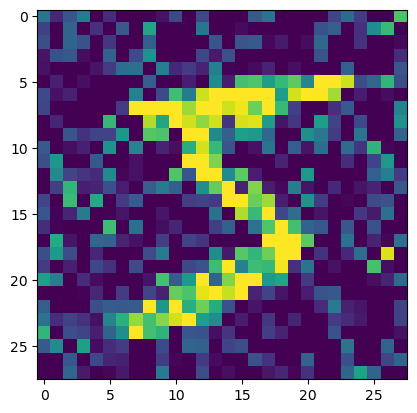

1/1 [==============================] - 0s 12ms/step
[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2523177e-12 0.0000000e+00
 1.0000000e+00 0.0000000e+00 0.0000000e+00 1.4509278e-31 3.0897497e-37]


In [17]:
quantized_noise = np.round(np.random.normal(loc = 0.0, scale = 0.3, size = image.shape) * 255.) / 255.

noisy_image = np.clip(image + quantized_noise, 0., 1.)
plt.imshow(noisy_image.reshape((28, 28)), vmin = 0., vmax = 1.)
plt.show()

def new_func(noisy_image):
    noisy_prediction = model1.predict(noisy_image)[0]
    print(noisy_prediction)

new_func(noisy_image)

`We will set up an adversarial sample generation.`

* First, we defined the custom activation function for keeping the adversarial pixel values between 0.0 and 1.0

In [18]:
def clip(x):
    return K.clip(x, 0.0, 1.0)

* Define Loss function for non-targeted misclassification

In [19]:
def negative_categorical_crossentropy(y_True, y_Prediction):
    return 0.0 - K.categorical_crossentropy(y_True, y_Prediction)

In [20]:
get_custom_objects().update({"clip": Activation(clip)})

get_custom_objects().update({"negative_categorical_crossentropy": negative_categorical_crossentropy})

Function for generating an adversarial example given a base image, aadversarial class target, classifier and regularization.

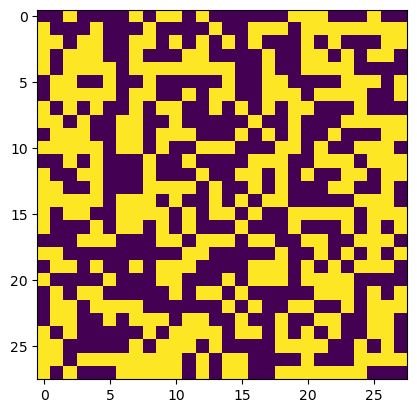

1/1 [==============================] - 0s 13ms/step


[[0.0000000e+00 0.0000000e+00 1.2613938e-12 2.4291905e-22 1.5256226e-35
  4.0260164e-28 0.0000000e+00 0.0000000e+00 1.0000000e+00 5.5831726e-37]]


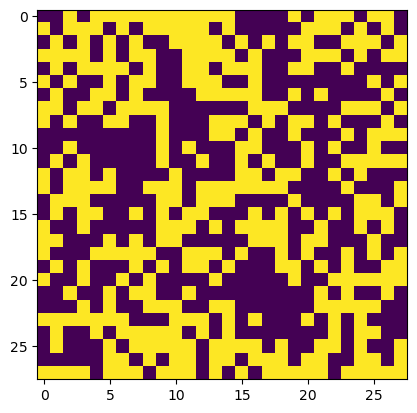

1/1 [==============================] - 0s 15ms/step


[[0.0000000e+00 0.0000000e+00 3.0731753e-01 1.0240338e-03 2.0270825e-29
  1.1109227e-30 0.0000000e+00 0.0000000e+00 6.9165844e-01 3.5755029e-30]]


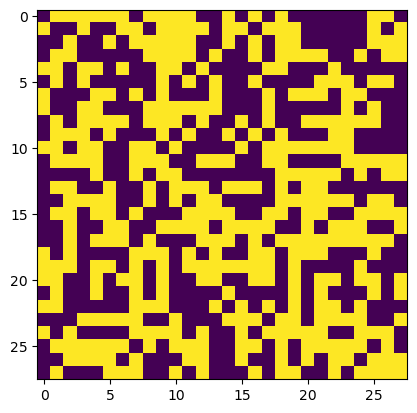

1/1 [==============================] - 0s 14ms/step


[[6.2704754e-32 0.0000000e+00 4.0453393e-04 0.0000000e+00 5.2024949e-09
  0.0000000e+00 3.3064914e-31 0.0000000e+00 9.9959546e-01 0.0000000e+00]]


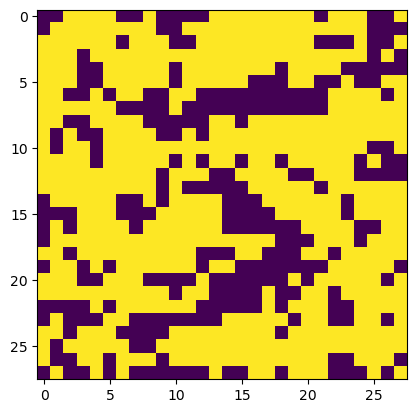

1/1 [==============================] - 0s 12ms/step


[[4.4848500e-31 0.0000000e+00 1.3112770e-34 2.5662120e-10 0.0000000e+00
  8.1567826e-08 0.0000000e+00 0.0000000e+00 9.9999988e-01 5.7004298e-33]]


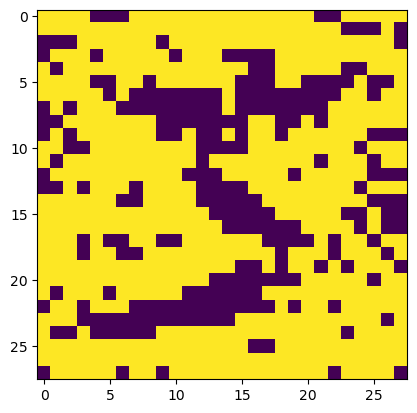

1/1 [==============================] - 0s 14ms/step


[[0.0000000e+00 0.0000000e+00 0.0000000e+00 7.5391586e-07 1.0256288e-30
  1.0554885e-08 0.0000000e+00 0.0000000e+00 9.9999928e-01 9.6828220e-32]]


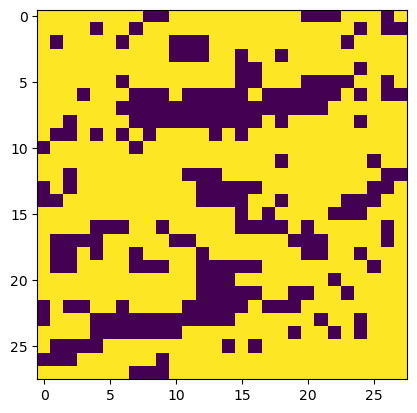

1/1 [==============================] - 0s 13ms/step
[[0.0000000e+00 0.0000000e+00 5.3317501e-22 3.6052827e-11 0.0000000e+00
  2.3219206e-17 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]


array([[1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

In [21]:
def generate_adversary(img, target, model, regularization, loss_function):
    # Input for base image
    image = Input(shape=(28, 28, 1), name='image')
    # Unit input for adversarial noise
    one = Input(shape=(1,), name='unity')

    # Layer for learning adversarial noise to apply to image
    noise = Dense(28 * 28, activation=None, use_bias=False,
                  kernel_initializer='random_normal', kernel_regularizer=regularization, name='adversarial_noise')(one)

    # Reshape noise in the shape of the image
    noise = Reshape((28, 28, 1), name='reshape')(noise)

    # Add noise to image
    net = Add(name='add')([noise, image])
    # Clip values to be within 0.0 and 1.0
    net = Activation('clip', name='clip_values')(net)

    # Feed adversarial image to trained MNIST classifier
    outputs = model(net)

    adversarial_model = Model(inputs=[image, one], outputs=outputs)
    # Freeze trained MNIST classifier layers
    adversarial_model.layers[-1].trainable = False

    adversarial_model.compile(optimizer=Nadam(), loss=loss_function, metrics=[categorical_accuracy])

    # Target adversarial classification
    target_vector = np.zeros(10)
    target_vector[target] = 1.

    # Callback for saving weights with the smallest loss
    checkpoint = ModelCheckpoint('./adversarial_weights.h5', monitor='loss', verbose=0, save_best_only=True,
                                 save_weights_only=True, mode='auto', period=1)
    # Train adversarial image
    adversarial_model.fit(x = {'image': img, 'unity': np.ones(shape=(1, 1))}, y=target_vector.reshape(1, -1),
                          epochs=10000, verbose=0, callbacks=[checkpoint])
    # Restore best weights
    adversarial_model.load_weights('./adversarial_weights.h5')

    # Quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((28, 28)) * 255.) / 255.

    # Add trained weights to the original image and clip values to produce an adversarial image
    adversarial_img = np.clip(img.reshape((28, 28)) + quantized_weights, 0., 1.)

    # Display adversarial image
    plt.imshow(adversarial_img, vmin=0., vmax=1.)
    plt.show()

    # Classify adversarial image
    adversarial_prediction = model.predict(adversarial_img.reshape((1, 28, 28, 1)))
    print(adversarial_prediction)

    return adversarial_img

# Example usage
generate_adversary(image, 5, model1, l1(0.01), 'negative_categorical_crossentropy')
generate_adversary(image, 5, model1, l2(0.01), 'negative_categorical_crossentropy')
generate_adversary(image, 5, model1, l1_l2(l1=0.01, l2=0.01), 'negative_categorical_crossentropy')

generate_adversary(image, 9, model1, l1(0.01), 'categorical_crossentropy')
generate_adversary(image, 9, model1, l2(0.01), 'categorical_crossentropy')
generate_adversary(image, 9, model1, l1_l2(l1=0.01, l2=0.01), 'categorical_crossentropy')
